# Stepwise function
# This file contains the stepwise function model and the corresponding EP curve.
# The last cell of this file is used to plot the Stepwise function values of different cubes, by changing the ID of cubes it can plot different Stepwise function values

MAE: 41827702.21381138
MSE: 2.228318255984359e+17
RMSE: 472050659.99152666
Number of equations 425
Number of layers 1300


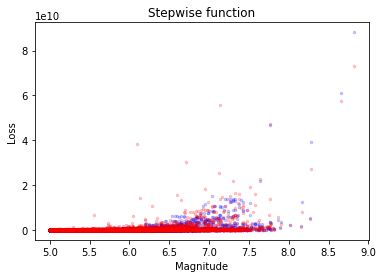

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def chekcbands(start, end, data):
    for i in range(start, end):
        if data[i]>data[i+1]:
            data[i+1]=data[i]
    return data

data= pd.read_csv('Greece_EQ_Euro_wDS_AIR_CT19.csv', sep=',')
train, test = train_test_split(data, test_size=0.2, random_state=42) 

# filter the data that are outside of area of interest
train= train.loc[train.Longitude.between(19, 31, inclusive="both") & train.Latitude.between(34, 43, inclusive="both")].reset_index()
test= test.loc[test.Longitude.between(19, 31, inclusive="both") & test.Latitude.between(34, 43, inclusive="both")].reset_index()

# train the general linear regression model in case no sufficient training data is available in a particular cube
general_X=train[['Magnitude','FocalDepth','Longitude','Latitude']]
general_y=train['Loss']

general_reg = LinearRegression()
general_reg.fit(general_X, general_y)


real_data = False # Set real_data to true if we want to make predictions on real data
if real_data: test = pd.read_csv('Real earthquakes.csv', sep=',') #if we want to make predictions on real data

test['predicted_loss']=0
x, xmax, resolution= 19, 31, 1
y, ymax= 34, 43
depth, maxdepth, depth_range =0, 200, 20
step = 0.1 # stepsize of the stepwise function 

numbers=1 # count the actual number of 
layers=0 # count the total number of layers
while x + resolution <= xmax:
    while y + resolution <= ymax:
        while depth + depth_range <= maxdepth:
            auxtrain= train.loc[train.Longitude.between(x, x+resolution, inclusive="left") & train.Latitude.between(y, y+resolution, inclusive="left") & train.FocalDepth.between(depth, depth+ depth_range, inclusive="left")].reset_index()
            auxtest= test.loc[test.Longitude.between(x, x+resolution, inclusive="left") & test.Latitude.between(y, y+resolution, inclusive="left") & test.FocalDepth.between(depth, depth+ depth_range, inclusive="left")].reset_index()
            
            # If training data in the cube is less than 10, use general linear regression
            if auxtrain.Magnitude.count()<10 and auxtest.Magnitude.count()!=0:
                prediction = general_reg.predict(auxtest[['Magnitude','FocalDepth','Longitude','Latitude']])
                test.predicted_loss.loc[test.Longitude.between(x, x+resolution, inclusive="left") & test.Latitude.between(y, y+resolution, inclusive="left") & test.FocalDepth.between(depth, depth+ depth_range, inclusive="left")]=prediction     
            elif auxtest.Magnitude.count()!=0:
                
                # Initialize the A matrix for LSQ solver
                bands = int(4 / step)
                A=np.zeros((auxtrain.shape[0], bands), np.int8)
                A=pd.DataFrame(A)
                A=A.join(auxtrain['Magnitude'])
                b=np.array(auxtrain['Loss'])
                a=5
                n=0
                
                # Check which band the magnitude belongs
                while a<9:
                    if len(A.iloc[:,n].loc[A['Magnitude'].between(a, a+step, inclusive='left')])>0:
                        A.iloc[:,n].loc[A['Magnitude'].between(a, a+step, inclusive='left')]= 1 
                    n+= 1 
                    a+= step
                A=np.array(A.drop('Magnitude', axis=1))

                C=np.zeros((bands,bands)) # Constraint matrix
                
                # Set the monotonically increasing constraint
                for n in range(bands-1):
                    C[n][n]=-1
                    C[n][n+1]=1
                m = cp.Variable(bands)  # The stepwise function value
               
                # Pass the objective and constraint to the solver
                objective = cp.Minimize(cp.sum_squares(A @ m - b))
                constraints = [0 <= C@m]
                prob = cp.Problem(objective, constraints)
                result = prob.solve()
                
                # Because of the performance of the LSQ solver, sometimes the monotonically constraint 
                # is not satisfied, to guarantee this constraint, we postprocess the index values by forcing
                # index with higher magnitude equal or higher than lower magnitude
                m.value = chekcbands(0, bands-1, m.value) # Make sure the constraints are satisfied 
                
                # Use the stepwise function value we just got to calculate the predicted loss
                T= np.zeros((auxtest.shape[0], bands), np.int8)
                T=pd.DataFrame(T)
                T=T.join(auxtest['Magnitude'])
                a=5
                n=0
                while a<9:
                    if len(T.iloc[:,n].loc[T['Magnitude'].between(a, a+step, inclusive='left')])>0:
                        T.iloc[:,n].loc[T['Magnitude'].between(a, a+step, inclusive='left')]= 1
                    n+= 1 
                    a+= step
                T=np.array(T.drop('Magnitude', axis=1))
                test.predicted_loss.loc[test.Longitude.between(x, x+resolution, inclusive="left") & test.Latitude.between(y, y+resolution, inclusive="left") & test.FocalDepth.between(depth, depth+ depth_range, inclusive="left")]=T@m.value
                numbers+=1

            depth+=depth_range
            layers+=1
        depth=0
        y+=resolution
    y=32
    #print(x)
    x+=resolution

result= test[['predicted_loss']]
test.predicted_loss.loc[test['predicted_loss']<0]=0 # make negative predictions of general LR to 0 
if not real_data:
    MSE= (test.predicted_loss - test.Loss) * (test.predicted_loss - test.Loss)
    print('MAE:', mean_absolute_error(test['Loss'],test['predicted_loss']))
    print('MSE:', MSE.mean())
    print('RMSE:', math.sqrt(MSE.mean()))
    print("Number of equations", numbers)
    print("Number of layers", layers)
    plt.plot(test['Magnitude'], test['predicted_loss'],'bo', markersize=2.5, alpha=0.2)
    plt.plot(test['Magnitude'], test['Loss'],'ro', markersize=2.5, alpha=0.2)
    #plt.plot(test['Loss'], test['predicted_loss'],'ro', markersize=2.5, alpha=0.2)
    plt.xlabel('Magnitude')
    plt.ylabel('Loss')
    plt.title('Stepwise function')
    #plt.savefig('Comparison of datas.pdf')
else:
    print(test)

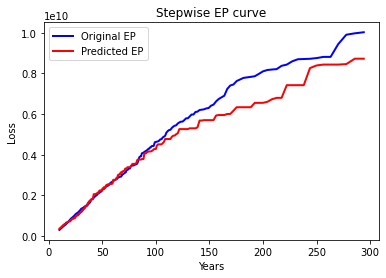

In [71]:
# Plot EP curve

test= test.sort_values(by='Loss',ascending=False, ignore_index=True)
rank= [10000/i for i in range(1,test.shape[0]+1)]
rank= pd.DataFrame(rank)
test['rp']= rank.values

result= result.sort_values(by='predicted_loss',ascending=False, ignore_index=True)
result['rp']= rank.values
result2=result.loc[result.rp.between(10, 300, inclusive="both")]
test2=test.loc[test.rp.between(10, 300, inclusive="both")]

plt.plot(test2['rp'], test2['Loss'], color="blue", linewidth=2, label='Original EP')
plt.plot(result2['rp'], result2['predicted_loss'], color="red", linewidth=2, label='Predicted EP')

plt.xlabel('Years')
plt.ylabel('Loss')
plt.title('Stepwise EP curve')
plt.legend()

#plt.savefig('Stepwise EP curve.pdf')

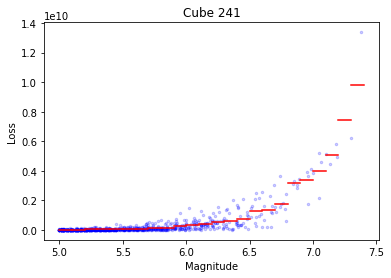

In [75]:
# Plot the Stepwise function of a specific cube

data= pd.read_csv('Greece_EQ_Euro_wDS_AIR_CT19.csv', sep=',')
cube= pd.read_csv('Cubeinfo.csv', sep=',')
cube = cube[cube['cube_ID']==241] # Set the cube ID we want to plot
#data= data.loc[data.Longitude.between(21, 22, inclusive="both") & data.Latitude.between(40, 41, inclusive="both") & data.FocalDepth.between(0, 20, inclusive="both")].reset_index()
data= data.loc[data.Longitude.between(cube.min_x.values[0], cube.max_x.values[0], inclusive="left") & data.Latitude.between(cube.min_y.values[0], cube.max_y.values[0], inclusive="left") & data.FocalDepth.between(cube.min_depth.values[0], cube.max_depth.values[0], inclusive="left")].reset_index()
data['predicted_loss']=0
step=0.1
bands= int(4/step)
A=np.zeros((data.shape[0], bands), np.int8)
A=pd.DataFrame(A)
A=A.join(data['Magnitude'])
b=np.array(data['Loss'])
a=5
n=0
while a<9:
    if len(A.iloc[:,n].loc[A['Magnitude'].between(a, a+step, inclusive='left')])>0:
        A.iloc[:,n].loc[A['Magnitude'].between(a, a+step, inclusive='left')]= 1 #A['Magnitude'].loc[A['Magnitude'].between(a, a+step, inclusive='left')]
    n+= 1 
    a+= step

A=np.array(A.drop('Magnitude', axis=1))
C=np.zeros((bands,bands))
for n in range(bands-1):
    C[n][n]=-1
    C[n][n+1]=1
    
m = cp.Variable(bands)
objective = cp.Minimize(cp.sum_squares(A @ m - b))
constraints = [0 <= C@m]
prob = cp.Problem(objective, constraints)
result = prob.solve()
data['predicted_loss'] =A@m.value
plt.xlabel('Magnitude')
plt.ylabel('Loss')
title= "Cube " + str(cube['cube_ID'].values[0])
plt.title(title)
plt.plot(data['Magnitude'], data['Loss'],'bo', markersize=2.5, alpha=0.2)
magnitude=5
k=0
while magnitude<data.Magnitude.max():
    plt.plot([magnitude, magnitude+step] , [m.value[k], m.value[k]], color='red')
    k+=1
    magnitude+=step
#plt.savefig('Stepwise function.pdf')